# 1-Metadata
This tutorial shows how to use Spark datasets to retrieve metadata about PDB structures. mmtfPyspark provides a number of moduls to fetch data from [external resources](https://github.com/sbl-sdsc/mmtf-pyspark/tree/master/mmtfPyspark/datasets).

In this tutorial shows how to download and analyze PDB metadata from the [SIFTS project](https://www.ebi.ac.uk/pdbe/docs/sifts/methodology.html) as Spark Datasets.


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import substring_index
from mmtfPyspark.datasets import pdbjMineDataset
import matplotlib.pyplot as plt

#### Configure Spark

In [2]:
spark = SparkSession.builder.appName("1-Metadata").getOrCreate()

## Download up to date EC classification data
The SIFTS project maintains up-to-date mappings of protein chains in the PDB to Enzyme Classifications [EC](http://www.sbcs.qmul.ac.uk/iubmb/enzyme/). We use the [pdbjMinedDataset class](https://github.com/sbl-sdsc/mmtf-pyspark/blob/master/mmtfPyspark/datasets/pdbjMineDataset.py) to retrieve these mappings. An extensive [demo](https://nbviewer.jupyter.org/github/sbl-sdsc/mmtf-pyspark/blob/master/demos/datasets/SiftsDataDemo.ipynb) shows how to query SIFTS data with pdbjMineDataset.

#### Query EC data

In [3]:
query = "SELECT * FROM sifts.pdb_chain_enzyme"
enzymes = pdbjMineDataset.get_dataset(query).cache()

In [4]:
enzymes.show()

+-----+-----+---------+---------+----------------+
|pdbid|chain|accession|ec_number|structureChainId|
+-----+-----+---------+---------+----------------+
| 102L|    A|   P00720| 3.2.1.17|          102L.A|
| 103L|    A|   P00720| 3.2.1.17|          103L.A|
| 104L|    A|   P00720| 3.2.1.17|          104L.A|
| 104L|    B|   P00720| 3.2.1.17|          104L.B|
| 107L|    A|   P00720| 3.2.1.17|          107L.A|
| 108L|    A|   P00720| 3.2.1.17|          108L.A|
| 109L|    A|   P00720| 3.2.1.17|          109L.A|
| 10GS|    A|   P09211| 2.5.1.18|          10GS.A|
| 10GS|    B|   P09211| 2.5.1.18|          10GS.B|
| 10MH|    A|   P05102| 2.1.1.37|          10MH.A|
| 110L|    A|   P00720| 3.2.1.17|          110L.A|
| 111L|    A|   P00720| 3.2.1.17|          111L.A|
| 112L|    A|   P00720| 3.2.1.17|          112L.A|
| 113L|    A|   P00720| 3.2.1.17|          113L.A|
| 114L|    A|   P00720| 3.2.1.17|          114L.A|
| 115L|    A|   P00720| 3.2.1.17|          115L.A|
| 117E|    A|   P00817|  3.6.1.

#### For better formatting, we can convert the dataset to pandas

In [5]:
enzymes.toPandas().head(20)

,pdbid,chain,accession,ec_number,structureChainId
0,102L,A,P00720,3.2.1.17,102L.A
1,103L,A,P00720,3.2.1.17,103L.A
2,104L,A,P00720,3.2.1.17,104L.A
3,104L,B,P00720,3.2.1.17,104L.B
4,107L,A,P00720,3.2.1.17,107L.A
5,108L,A,P00720,3.2.1.17,108L.A
6,109L,A,P00720,3.2.1.17,109L.A
7,10GS,A,P09211,2.5.1.18,10GS.A
8,10GS,B,P09211,2.5.1.18,10GS.B
9,10MH,A,P05102,2.1.1.37,10MH.A


## Remove redundcancy 
Here we select a single protein chain for each unique UniProt accession number

In [6]:
enzymes = enzymes.dropDuplicates(["accession"])

## Add a columns for enzyme type and subtype
We use the [withColumn](http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html#pyspark.sql.DataFrame.withColumn) method to add a new column and the [substring_index](http://spark.apache.org/docs/2.3.0/api/python/pyspark.sql.html#pyspark.sql.functions.substring_index) method to extract the first two levels from the EC number hierarchy.

In [7]:
enzymes = enzymes.withColumn("enzymeType", substring_index(enzymes.ec_number, '.', 1))
enzymes = enzymes.withColumn("enzymeSubtype", substring_index(enzymes.ec_number, '.', 2))

In [8]:
enzymes.toPandas().head(20)

,pdbid,chain,accession,ec_number,structureChainId,enzymeType,enzymeSubtype
0,3P96,A,A0QJI1,3.1.3.3,3P96.A,3,3.1
1,2IXA,A,A4Q8F7,3.2.1.49,2IXA.A,3,3.2
2,6IDO,A,A6TGP0,2.7.7.6,6IDO.A,2,2.7
3,3FIE,A,A7GBG3,3.4.24.69,3FIE.A,3,3.4
4,4Z38,A,A7Z470,2.3.1.39,4Z38.A,2,2.3
5,6DRE,B,A8GG78,2.4.2.31,6DRE.B,2,2.4
6,3ZH4,A,B1IBM3,2.5.1.7,3ZH4.A,2,2.5
7,6CYZ,A,B1MLU6,2.7.1.39,6CYZ.A,2,2.7
8,2FUQ,A,C6XZB6,4.2.2.7,2FUQ.A,4,4.2
9,3C61,A,D0VWT2,1.3.98.1,3C61.A,1,1.3


## Count the occurance of the enzyme types

In [9]:
counts = enzymes.groupBy("enzymeType")\
                .count()\
                .sort("count", ascending=False)\
                .toPandas()
        
counts

,enzymeType,count
0,2,4911
1,3,4635
2,1,2799
3,4,1203
4,5,805
5,6,620
6,7,261


## Use pandas to plot the occurances with Matplotlib

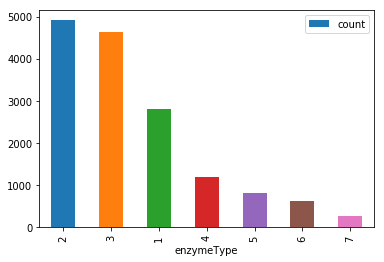

In [10]:
counts.plot(x='enzymeType', y='count', kind='bar');

In [11]:
spark.stop()